In [35]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr

# Problem 1

### First we generate paths of 10000 stocks over 1000 periods

In [2]:
# define num of periods and num of stocks
periods = 1000
num_stocks = 10000

# a function to generate one stock path
def gen_one_path():
    p = [1]
    for i in range(1,periods):
        p.append((1+0.007*np.random.normal(0,1))*p[i-1])
    return np.array(p)

In [3]:
# store all paths into a list
paths = []
for i in range(num_stocks):
    paths.append(gen_one_path())

Here we can plot 50 sample paths:

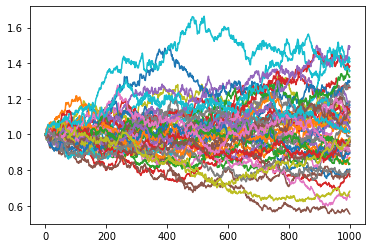

In [4]:
for i in range(50):
    plt.plot(paths[i])

From the previous figure, generally our stock paths follow the random walk as specified in the homework instruction.

### Then we apply our selecting rule to generate Russell 1000 index

In [5]:
def update_index(start,end):
    """return the index from start time to end time
    
    start: the update time
    end: the next update time
    """
    index = np.repeat(0.0,end-start)
    path = []
    for i in paths:
        path.append(i[start])
    tops = np.argsort(path)[-1000:]
    for i in tops:
        index+=paths[i][start:end]
    return index/1000

In [6]:
# select stocks into Russell 1000 index
update_time = np.arange(1,1000,50)
update_time = np.append(update_time,1000)
index = np.array([])
index_mean = np.array([])
for i in range(1,len(update_time)):
    new_index = update_index(update_time[i-1],update_time[i])
    index=np.append(index, new_index)
index = np.append(1,index)

windows = np.arange(0,1001,100)
for i in range(1,len(windows)):
    mean = index[windows[i-1]:windows[i]].mean()
    index_mean = np.append(index_mean, mean)

## Q1: Plot simulated Russell 1000 Index

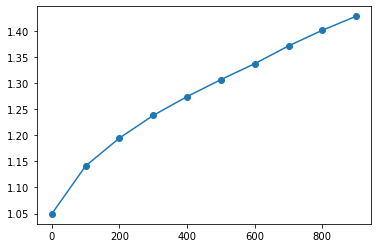

In [7]:
plt.scatter(np.arange(0,1000,100),index_mean)
plt.plot(np.arange(0,1000,100),index_mean)
plt.show()

It seems reasonable because we select 1000 stocks with laregest market cap every 50 periods. In each window(every 100 periods), there's one re-seleciton, so the average Russell 1000 index keeps going up.

### After we have the path of Russell 1000 index, we can claculate the average return of index in each window

In [8]:
windows[-1]=999
re1 = np.array([])
for i in range(1,len(windows)):
    returns = (index[windows[i]] - index[windows[i-1]])/index[windows[i-1]]
    re1 = np.append(re1,returns/100)

## Q2: Plot the average return of Russell 1000 Index

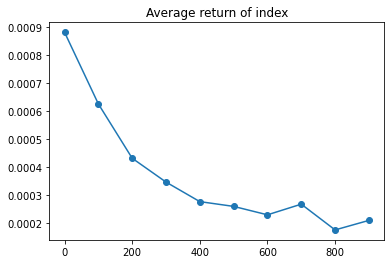

In [9]:
plt.title("Average return of index")
plt.scatter(np.arange(0,1000,100),re1)
plt.plot(np.arange(0,1000,100),re1)
plt.show()

From the figure we find that the average return of index in each windows keeps going down, it's because the number of stocks performing better than the Russell 1000 index becomes smaller as selecting the stocks into the index again and again.

### Then we calculate the average return of 10000 stocks in each window

In [10]:
re2 = np.array([])
for i in range(1,len(windows)):
    returns = 0
    for j in paths:
        returns += (j[i]-j[i-1])/j[i]
    re2 = np.append(re2,returns/100/len(paths))

## Q3: Plot the average return of the 10,000 stocks

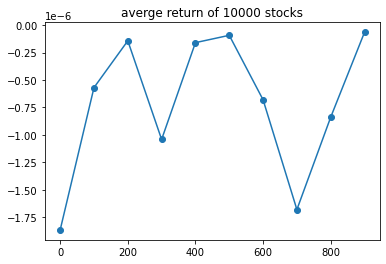

In [11]:
plt.title("averge return of 10000 stocks")
plt.scatter(np.arange(0,1000,100),re2)
plt.plot(np.arange(0,1000,100),re2)
plt.show()

From the figure we find that the average return of 1000 index fluctuates around 0, it's proper because our 10000 stocks' paths are random walks.

## Q4:

- Obviously, even from the shape of figures of **Q2** and **Q3** we can conclude that Russell 1000 index cannot represent the performance of the whole market.

- The average return of Russell 1000 index is larger than the average return of 10000 stocks. Because in every window, we will always re-select the stocks that have the largest market cap, which drives the return of Russell 1000 index dramatically up.

# Problem 2

### Download data (Ajusted price of 11 ETFs and SPY) 

In [2]:
import yfinance as yf
symbols = ['VOX','VCR', 'VDC', 'VDE', 'VFH', 'VHT', 'VIS', 'VGT', 'VAW', 'VNQ', 'VPU', 'SPY']
secs = ['COMM', 'CONSUMER DISC', 'CONSUMER ST', 'ENERGY', 'FINANCIALS', 'HEALTH', 'INDUSTRIALS', 
           'TECHNOLOGY', 'MATIREALS', 'REAL ESTATE', 'UTILITIES']
start = '2010-1-1'
end = '2020-12-31'
data = yf.download(symbols,start,end)['Adj Close'] 
data.head()

[*********************100%***********************]  12 of 12 completed


,SPY,VAW,VCR,VDC,VDE,VFH,VGT,VHT,VIS,VNQ,VOX,VPU
Date,,,,,,,,,,,,
2010-01-04,90.205025,56.640865,40.879322,49.588459,63.985840,23.370378,49.731956,46.846149,43.845570,28.118280,43.386734,44.064613
2010-01-05,90.443848,56.981342,41.139496,49.633289,64.640800,23.631197,49.678493,46.556240,44.037518,28.086721,43.679882,43.654045
2010-01-06,90.507484,57.783894,41.182846,49.625832,65.385078,23.670712,49.330902,46.820564,44.146011,28.036238,42.988342,43.849232
2010-01-07,90.889542,57.532597,41.538391,49.625832,65.228798,24.129110,49.143734,46.982571,44.688442,28.339197,42.830490,43.654045
2010-01-08,91.192001,58.156807,41.573078,49.356812,65.720024,24.034267,49.526966,47.153114,45.280949,28.130909,42.635059,43.606930


### Calculate log return

In [3]:
returns = data.pct_change()
returns = returns.dropna()
returns.head()

,SPY,VAW,VCR,VDC,VDE,VFH,VGT,VHT,VIS,VNQ,VOX,VPU
Date,,,,,,,,,,,,
2010-01-05,0.002648,0.006011,0.006364,0.000904,0.010236,0.011160,-0.001075,-0.006189,0.004378,-0.001122,0.006757,-0.009317
2010-01-06,0.000704,0.014084,0.001054,-0.000150,0.011514,0.001672,-0.006997,0.005678,0.002464,-0.001797,-0.015832,0.004471
2010-01-07,0.004221,-0.004349,0.008633,0.000000,-0.002390,0.019366,-0.003794,0.003460,0.012287,0.010806,-0.003672,-0.004451
2010-01-08,0.003328,0.010850,0.000835,-0.005421,0.007531,-0.003931,0.007798,0.003630,0.013259,-0.007350,-0.004563,-0.001079
2010-01-11,0.001397,-0.003346,-0.001251,0.003482,-0.000793,-0.000329,-0.004319,0.005064,0.009399,0.005834,0.000881,0.007717


## Q1: Plot the return processes of the 11 selected sector ETFs and the S&P 500 index.

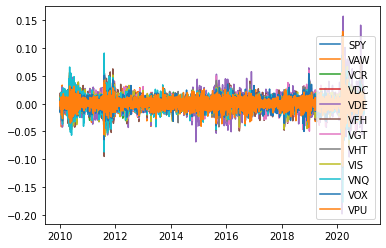

In [6]:
for col in returns.columns:
    plt.plot(returns[col], label = col)
plt.legend()
plt.show()

Then we create a dataframe consisting of the return of 11 etfs so as to do factor analysis

In [18]:
df = returns.loc[:,['VOX','VCR', 'VDC', 'VDE', 'VFH', 'VHT', 'VIS', 'VGT', 'VAW', 'VNQ', 'VPU']]
df.head()

,VOX,VCR,VDC,VDE,VFH,VHT,VIS,VGT,VAW,VNQ,VPU
Date,,,,,,,,,,,
2010-01-05,0.006757,0.006364,0.000904,0.010236,0.011160,-0.006189,0.004378,-0.001075,0.006011,-0.001122,-0.009317
2010-01-06,-0.015832,0.001054,-0.000150,0.011514,0.001672,0.005678,0.002464,-0.006997,0.014084,-0.001797,0.004471
2010-01-07,-0.003672,0.008633,0.000000,-0.002390,0.019366,0.003460,0.012287,-0.003794,-0.004349,0.010806,-0.004451
2010-01-08,-0.004563,0.000835,-0.005421,0.007531,-0.003931,0.003630,0.013259,0.007798,0.010850,-0.007350,-0.001079
2010-01-11,0.000881,-0.001251,0.003482,-0.000793,-0.000329,0.005064,0.009399,-0.004319,-0.003346,0.005834,0.007717


In [36]:
tmp_fts = returns.copy()
def r2(x, y):
    return pearsonr(x, y)[0] ** 2
tmp_fts

,SPY,VAW,VCR,VDC,VDE,VFH,VGT,VHT,VIS,VNQ,VOX,VPU
Date,,,,,,,,,,,,
2010-01-05,0.002648,0.006011,0.006364,0.000904,0.010236,0.011160,-0.001075,-0.006189,0.004378,-0.001122,0.006757,-0.009317
2010-01-06,0.000704,0.014084,0.001054,-0.000150,0.011514,0.001672,-0.006997,0.005678,0.002464,-0.001797,-0.015832,0.004471
2010-01-07,0.004221,-0.004349,0.008633,0.000000,-0.002390,0.019366,-0.003794,0.003460,0.012287,0.010806,-0.003672,-0.004451
2010-01-08,0.003328,0.010850,0.000835,-0.005421,0.007531,-0.003931,0.007798,0.003630,0.013259,-0.007350,-0.004563,-0.001079
2010-01-11,0.001397,-0.003346,-0.001251,0.003482,-0.000793,-0.000329,-0.004319,0.005064,0.009399,0.005834,0.000881,0.007717
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23,0.000899,0.002787,0.000847,0.004158,0.025341,0.016456,-0.009102,0.001309,0.005703,-0.006468,0.006795,-0.001725
2020-12-24,0.003890,0.005366,0.001949,0.004257,-0.008365,0.000419,0.006647,0.001397,0.000650,0.008755,0.000675,0.006009
2020-12-28,0.008591,-0.004051,0.008002,0.006504,-0.007285,0.003767,0.007028,-0.002971,-0.000531,0.005961,0.012478,0.005674


In [37]:
fig, axs = plt.subplots(ncols=2, nrows=0, figsize=(10, 40))
plt.subplots_adjust(right=2.5)
plt.subplots_adjust(top=2)

cm = plt.get_cmap('jet')
colors = np.linspace(0.1, 1, len(tmp_fts))

for i, feature in enumerate(list(tmp_fts), 1):
    if(feature=='SPY'):
        break
        
    ic, pval = spearmanr(tmp_fts[feature], tmp_fts['SPY'])
    R2 = r2(tmp_fts[feature], tmp_fts['SPY'])
        
    plt.subplot(len(list(tmp_fts.columns)), 3, i)
    sc = plt.scatter(tmp_fts[feature], tmp_fts['SPY'], s=200, 
                 edgecolor='k', alpha=0.5, label='Price Data', c=colors, cmap=cm)
    j = sns.regplot(tmp_fts[feature], tmp_fts['SPY'], data=tmp_fts, scatter=False, label=False, 
                line_kws={'color':'k','lw':2.5, 'alpha':0.65})
    
    plt.ylabel('SPY', size=23, labelpad=14, fontsize=20, fontweight='medium')
    
    plt.title(f'{feature}: r2 = {round(R2,2)}', fontsize=23, fontweight='medium')
    plt.grid(False)
            
    for j in range(2):
        plt.tick_params(axis='x', labelsize=20)
        plt.tick_params(axis='y', labelsize=20)
        
plt.show() 

<Figure size 720x2880 with 0 Axes>

In [16]:
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

### Bartlett’s test of sphericity checks whether or not the observed variables intercorrelate at all 

In [23]:
chi_square_value,p_value=calculate_bartlett_sphericity(df)
chi_square_value,p_value

(37073.58410196048, 0.0)

The p-value is 0. The test was statistically significant, indicating that the observed correlation matrix is not an identity matrix.

### Kaiser-Meyer-Olkin (KMO) Test measures the suitability of data for factor analysis. 

In [24]:
kmo_all,kmo_model=calculate_kmo(df)
kmo_model

/opt/anaconda3/lib/python3.8/site-packages/factor_analyzer/utils.py:248: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '


0.9471425292306554

The overall KMO for our data is 0.94, which is excellent.

### Create factor analysis object and perform factor analysis

In [25]:
fa = FactorAnalyzer(n_factors=25, rotation=None)
fa.fit(df)
ev, v = fa.get_eigenvalues()
ev # eigenvalues

array([8.2827155 , 0.77087042, 0.51717624, 0.29609501, 0.27969878,
       0.20166592, 0.19410116, 0.16009368, 0.1325768 , 0.09917471,
       0.06583176])

### Scree plot

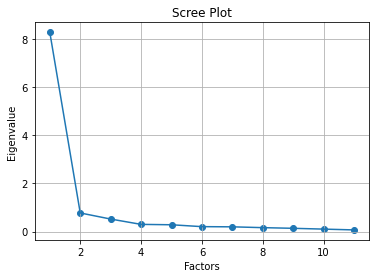

In [26]:
# Create scree plot using matplotlib
plt.scatter(range(1,df.shape[1]+1),ev)
plt.plot(range(1,df.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

## Q2: use the varimax method to find a final rotated factor solution, which is the loadings

- From the scree plot, we may choose 2 or 3 or 4 factors in our model, we first choose a 4 factor model

In [27]:
fa = FactorAnalyzer(n_factors=4, rotation="varimax")
fa.fit(df)
loadings = pd.DataFrame(fa.loadings_)
loadings.index = df.columns
loadings.columns = ['factor1','factor2','factor3','factor4']

# highlight the factors which are larger than .5
def style_highlight(v, props=''):
    return props if v > 0.5 else None
loadings_hightlight = loadings.style.applymap(style_highlight, props='color:red;')
loadings_hightlight

,factor1,factor2,factor3,factor4
VOX,0.410466,0.609959,0.376963,0.193972
VCR,0.489969,0.728051,0.273568,0.264277
VDC,0.321249,0.472676,0.719526,0.117476
VDE,0.734203,0.312238,0.249344,0.155897
VFH,0.674354,0.455131,0.332321,0.281255
VHT,0.411484,0.623390,0.426334,0.145048
VIS,0.703501,0.523453,0.340473,0.219489
VGT,0.413711,0.772021,0.283757,0.168443
VAW,0.728799,0.470427,0.319832,0.191336
VNQ,0.365393,0.307730,0.527397,0.699769


We can find that factor4 only have one high factor loading, so we consider a model that has only 3 factors

In [28]:
fa = FactorAnalyzer(n_factors=3, rotation="varimax")
fa.fit(df)
loadings = pd.DataFrame(fa.loadings_)
loadings.index = df.columns
loadings.columns = ['factor1','factor2','factor3']

# highlight the factors which are larger than .5
def style_highlight(v, props=''):
    return props if v > 0.5 else None
loadings_hightlight = loadings.style.applymap(style_highlight, props='color:red;')
loadings_hightlight

,factor1,factor2,factor3
VOX,0.429672,0.630153,0.376165
VCR,0.534355,0.720488,0.306040
VDC,0.335487,0.523337,0.622756
VDE,0.732238,0.320621,0.263133
VFH,0.712489,0.459573,0.370938
VHT,0.419507,0.652412,0.396981
VIS,0.726878,0.530229,0.353639
VGT,0.435826,0.777554,0.277962
VAW,0.741745,0.479135,0.327710
VNQ,0.463355,0.377836,0.612160


Now we look at the model with 2 factors

In [29]:
fa = FactorAnalyzer(n_factors=2, rotation="varimax")
fa.fit(df)
loadings = pd.DataFrame(fa.loadings_)
loadings.index = df.columns
loadings.columns = ['factor1','factor2']

# highlight the factors which are larger than .5
def style_highlight(v, props=''):
    return props if v > 0.5 else None
loadings_hightlight = loadings.style.applymap(style_highlight, props='color:red;')
loadings_hightlight

,factor1,factor2
VOX,0.716570,0.431418
VCR,0.857187,0.372094
VDC,0.564538,0.661346
VDE,0.728018,0.297289
VFH,0.813571,0.406731
VHT,0.722191,0.453260
VIS,0.875133,0.395684
VGT,0.809353,0.359871
VAW,0.848783,0.368389
VNQ,0.562749,0.638739


Now every factor has 3 or more high factor loadings, so I decide to choose a 2 factor model in this problem

### Regression and prediction

The model is

$$
    r_t = \mathbf{\beta}f_t + \epsilon_t
$$

#### return of SPY

In [39]:
spy_return = returns['SPY']

#### Transformation

In [40]:
new_v = fa.transform(df)
new_v = pd.DataFrame(new_v)
new_v.index = spy_return.index
new_v.columns = ['factor1', 'factor2']

In [41]:
new_data = new_v.join(spy_return)
new_data.columns = ['factor1', 'factor2','spy']
new_data

,factor1,factor2,spy
Date,,,
2010-01-05,0.821345,-0.979320,0.002647
2010-01-06,0.032370,0.163131,0.000704
2010-01-07,0.724294,-0.448871,0.004221
2010-01-08,0.711099,-0.638998,0.003328
2010-01-11,-0.158271,0.651622,0.001397
...,...,...,...
2020-12-23,0.452836,-0.274389,0.000899
2020-12-24,-0.106492,0.558920,0.003890
2020-12-28,-0.082478,0.624210,0.008591


In [42]:
from statsmodels.api import OLS, add_constant

In [43]:
factors = OLS(new_data.spy, add_constant(new_data[['factor1', 'factor2']])).fit()
factors = factors.params

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [44]:
new_data['pred'] = new_data.factor1 * factors.factor1 + new_data.factor2*factors.factor2 + factors.const

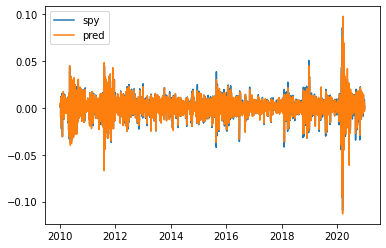

In [45]:
plt.plot(new_data.spy,label='spy')
plt.plot(new_data.pred,label='pred')
plt.legend()
plt.show()

In [46]:
new_data[['spy','pred']]

,spy,pred
Date,,
2010-01-05,0.002647,0.003267
2010-01-06,0.000704,0.001721
2010-01-07,0.004221,0.005100
2010-01-08,0.003328,0.003989
2010-01-11,0.001397,0.002450
...,...,...
2020-12-23,0.000899,0.003434
2020-12-24,0.003890,0.002460
2020-12-28,0.008591,0.003026


From the figure we can find that our factor model can mimic the return process of S&P 500 index

## Q3: Apply the factor sorting method

### We now choose the facotr1 which is the most important factor and then we sort them:

In [436]:
factor_sort = loadings.loc[:,'factor1']
factor_sort.index = secs

In [437]:
factor_sort = factor_sort.sort_values()
factor_sort

UTILITIES        0.271676
REAL ESTATE      0.562749
CONSUMER ST      0.564539
COMM             0.716570
HEALTH           0.722191
ENERGY           0.728019
TECHNOLOGY       0.809353
FINANCIALS       0.813571
MATIREALS        0.848784
CONSUMER DISC    0.857187
INDUSTRIALS      0.875133
Name: factor1, dtype: float64

From the table above, we short the **UTILITIES, CONSUMER ST, REAL ESTATE** sectors and long **INDUSTRIALS, MATIREALS, CONSUMER DISC** sectors